In [68]:
import os
import random
import copy
import warnings

# Dataframe
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from utils.prophet_data_loader import change2close

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error

import optuna
from optuna import Trial
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings('ignore')

In [2]:
start_date = '2010-01-01'
end_date = '2022-12-31'

In [3]:
data = pd.read_csv('./data/kospi.csv').dropna()
data = data[data['Date'] <= end_date]
data['Change'] = data['Kospi'].pct_change() * 100
data.loc[0, 'Change'] = 0
data

,Date,Kospi,USD/KRW,GDP,IAIP,LIR,M1,disease,Change
0,2010-01-04,1696.140015,1132.400024,1143.67,79.3,5.350,59.71815,0,0.000000
1,2010-01-05,1690.619995,1141.300049,1143.67,79.3,5.350,59.71815,0,-0.325446
2,2010-01-06,1705.319946,1130.400024,1143.67,79.3,5.350,59.71815,0,0.869501
3,2010-01-07,1683.449951,1134.900024,1143.67,79.3,5.350,59.71815,0,-1.282457
4,2010-01-08,1695.260010,1123.099976,1143.67,79.3,5.350,59.71815,0,0.701539
...,...,...,...,...,...,...,...,...,...
3198,2022-12-23,2313.689941,1290.199951,1673.92,126.0,3.541,193.79220,0,-1.826261
3199,2022-12-26,2317.139893,1279.239990,1673.92,126.0,3.541,193.79220,0,0.149110
3200,2022-12-27,2332.790039,1275.130005,1673.92,126.0,3.541,193.79220,0,0.675408
3201,2022-12-28,2280.449951,1272.280029,1673.92,126.0,3.541,193.79220,0,-2.243669


In [4]:
split_date = '2021-12-31'

# train, valid, test 데이터 나누기
train_data = data.loc[data['Date'] <= split_date].copy()
test_data = data.loc[data['Date'] > split_date].copy()

In [5]:
print("Train 데이터 크기:", len(train_data))
print("Test 데이터 크기:", len(test_data))

Train 데이터 크기: 2959
Test 데이터 크기: 244


In [6]:
data.rename(columns={'Date': 'ds', 'Change': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

train_data.rename(columns={'Date': 'ds', 'Change': 'y'}, inplace=True)
train_data['ds'] = pd.to_datetime(train_data['ds'])

test_data.rename(columns={'Date': 'ds', 'Change': 'y'}, inplace=True)
test_data['ds'] = pd.to_datetime(test_data['ds'])

In [7]:
regressor_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']

# 가능한 모든 조합의 리스트 생성
all_combinations = []
for r in range(1, len(regressor_columns) + 1):
    all_combinations.extend(combinations(regressor_columns, r))

regressor_combinations = ['_'.join(combination) for combination in all_combinations]

In [8]:
regressor_column = regressor_combinations[0]
regressor_column

'USD/KRW'

In [9]:
train_data.iloc[:, :2]

,ds,Kospi
0,2010-01-04,1696.140015
1,2010-01-05,1690.619995
2,2010-01-06,1705.319946
3,2010-01-07,1683.449951
4,2010-01-08,1695.260010
...,...,...
2954,2021-12-24,3012.429932
2955,2021-12-27,2999.550049
2956,2021-12-28,3020.239990
2957,2021-12-29,2993.290039


19:36:24 - cmdstanpy - INFO - Chain [1] start processing
19:36:24 - cmdstanpy - INFO - Chain [1] done processing


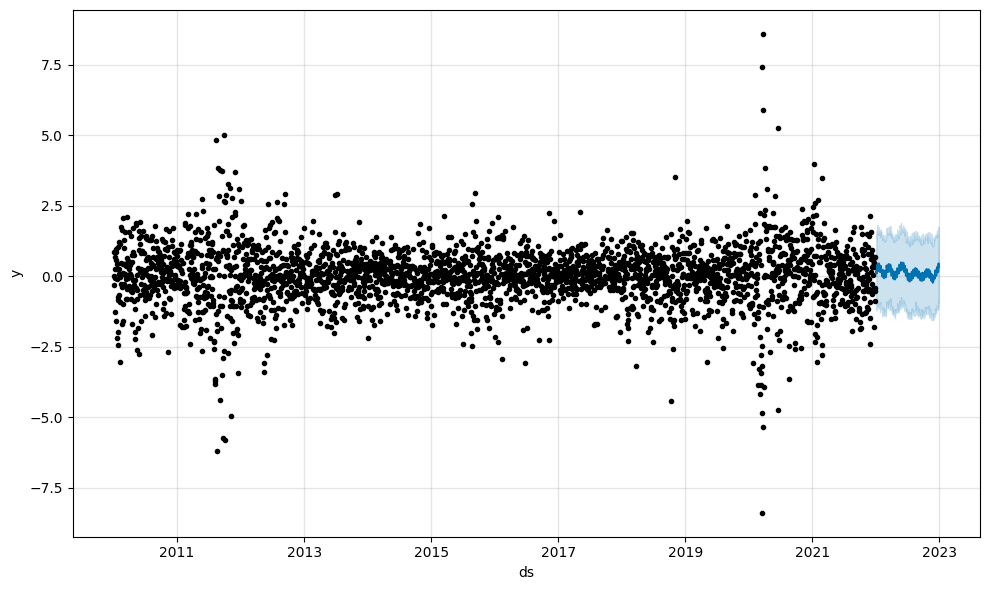

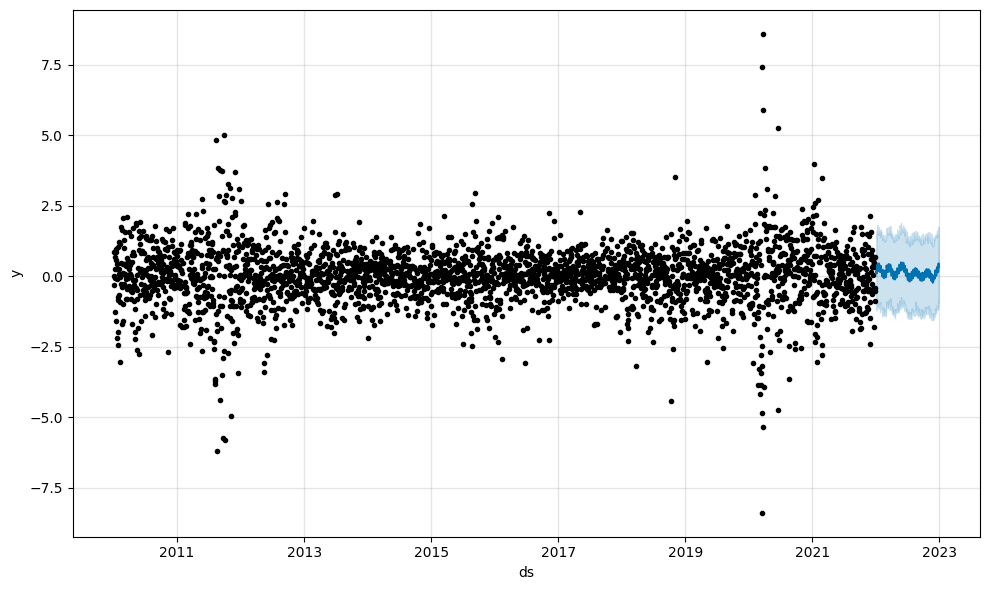

In [10]:
m = Prophet(changepoints=['2015-12-23', '2015-05-20', '2020-01-20'])

regressor_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']

for col in regressor_columns:
    m.add_regressor(col)
m.fit(train_data)

future = m.make_future_dataframe(periods=len(test_data), include_history=False)

for col in regressor_columns:
    future[col] = test_data[col].values

forecast = m.predict(future)
forecast['ds'].iloc[:] = pd.to_datetime(test_data['ds']).iloc[:]
m.plot(forecast)

In [11]:
def train(train_data,regressors=[], **kwargs):
    
    model = Prophet(
        **kwargs,
        growth='linear',
    )
    
    columns = regressors.split('_')
    
    for col in columns:
        model.add_regressor(col)
    
    model.fit(train_data)
    train_cv = cross_validation(model, initial=f'2070 days', period='90 days', horizon='30 days', disable_tqdm=True)
    
    train_p = performance_metrics(train_cv)
    
    return model, train_cv, train_p

In [12]:
def test(model: Prophet, test_data, regressors=[], **kwargs):
    columns = regressors.split('_')
    
    # 예측 및 평가
    future = model.make_future_dataframe(periods=len(test_data), include_history=False)
    
    for col in columns:
        future[col] = test_data[col].values
    
    forecast = model.predict(future)
    rmse = np.sqrt(mean_squared_error(test_data["y"], forecast["yhat"]))

    return rmse, forecast

In [13]:
params_grid = {
    "changepoints": [None, ['2015-12-23', '2015-05-20', '2020-01-20']],
    "n_changepoints": [10, 20, 50],
    "seasonality_mode": ["additive", "multiplicative"],
    'seasonality_prior_scale': [5, 10, 20],
    "changepoint_prior_scale": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    # "regressors": regressor_combinations
}
grid = ParameterGrid(params_grid)

cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 324


In [14]:
regressor_combinations[-1]

'USD/KRW_GDP_IAIP_LIR_M1_disease'

In [15]:
model_parameters = []
for p in grid:
    _, _, train_p = train(train_data, regressor_column, **p)
    rmse = round(train_p["rmse"].mean(),1)
    smape = round(train_p["smape"].mean(),1)
    p['RMSE'] = rmse
    p['SMAPE'] = smape
    p = {k: [v] for k, v in p.items()}
    model_parameters.append(pd.DataFrame(p))
model_parameters = pd.concat(model_parameters, ignore_index=True)

19:36:25 - cmdstanpy - INFO - Chain [1] start processing
19:36:25 - cmdstanpy - INFO - Chain [1] done processing
19:36:25 - cmdstanpy - INFO - Chain [1] start processing
19:36:25 - cmdstanpy - INFO - Chain [1] done processing
19:36:25 - cmdstanpy - INFO - Chain [1] start processing
19:36:25 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:26 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:27 - cmdstanpy - INFO - Chain [1] start processing
19:36:27 - cmdstanpy - INFO - Chain [1]

In [16]:
model_parameters

,changepoint_prior_scale,changepoints,n_changepoints,seasonality_mode,seasonality_prior_scale,RMSE,SMAPE
0,0.1,None,10,additive,5,1.2,1.6
1,0.1,None,10,additive,10,1.2,1.6
2,0.1,None,10,additive,20,1.2,1.6
3,0.1,None,10,multiplicative,5,1.2,1.7
4,0.1,None,10,multiplicative,10,1.2,1.7
...,...,...,...,...,...,...,...
319,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",50,additive,10,1.2,1.5
320,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",50,additive,20,1.2,1.5
321,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",50,multiplicative,5,1.7,1.6
322,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",50,multiplicative,10,1.7,1.6


In [17]:
model_parameters_sorted = model_parameters.sort_values(by=['RMSE'], ascending=True)
min_rmse_group = model_parameters_sorted[model_parameters_sorted['RMSE'] == model_parameters_sorted['RMSE'].min()]
min_rmse_smape_group = min_rmse_group[min_rmse_group['SMAPE'] == min_rmse_group['SMAPE'].min()]
min_rmse_smape_group

,changepoint_prior_scale,changepoints,n_changepoints,seasonality_mode,seasonality_prior_scale,RMSE,SMAPE
320,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",50,additive,20,1.2,1.5
319,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",50,additive,10,1.2,1.5
318,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",50,additive,5,1.2,1.5
314,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",20,additive,20,1.2,1.5
313,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",20,additive,10,1.2,1.5
312,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",20,additive,5,1.2,1.5
308,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",10,additive,20,1.2,1.5
306,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",10,additive,5,1.2,1.5
307,0.9,"[2015-12-23, 2015-05-20, 2020-01-20]",10,additive,10,1.2,1.5


In [18]:
best_params = min_rmse_smape_group.iloc[:, :5].to_dict('records')

In [19]:
best_params

[{'changepoint_prior_scale': 0.9,
  'changepoints': ['2015-12-23', '2015-05-20', '2020-01-20'],
  'n_changepoints': 50,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.9,
  'changepoints': ['2015-12-23', '2015-05-20', '2020-01-20'],
  'n_changepoints': 50,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.9,
  'changepoints': ['2015-12-23', '2015-05-20', '2020-01-20'],
  'n_changepoints': 50,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.9,
  'changepoints': ['2015-12-23', '2015-05-20', '2020-01-20'],
  'n_changepoints': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.9,
  'changepoints': ['2015-12-23', '2015-05-20', '2020-01-20'],
  'n_changepoints': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.9,
  'changepoints': ['2015-12

In [20]:
def plot_stock_forecast(data, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
    plt.plot(pd.to_datetime(data['ds']), data['y'], label='Actual', color='blue')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
    plt.title('Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [39]:
def printResult(test_datelist, test_true, test_forecast):
    test_result_list = []
    for date in test_datelist:
        test_result_list.append([date, test_true[date], test_forecast[date]])
    test_yyyymm = []
    test_start_y = test_result_list[0][0].year
    test_end_y = test_result_list[-1][0].year
    test_start_m = test_result_list[0][0].month
    test_end_m = test_result_list[-1][0].month
    
    if (test_start_y == test_end_y):
        for i in range(test_start_m, test_end_m + 1):
            test_yyyymm.append(test_start_y * 100 + i)
    else:
        for i in range(test_end_y - test_start_y + 1):
            if (i == 0):
                for j in range(test_start_m, 13):
                    test_yyyymm.append((test_start_y + i) * 100 + j)
            elif (i == (test_end_y - test_start_y)):
                for j in range(1, test_end_m + 1):
                    test_yyyymm.append((test_start_y + i) * 100 + j)
            else:
                for j in range(1, 13):
                    test_yyyymm.append((test_start_y + i) * 100 + j) 
                    
    test_month_tf = {}
    errorRates = []
    for i in range(len(test_yyyymm)):
        test_month_tf[test_yyyymm[i]] = [0, 0]
    for i in range(len(test_result_list)):
        key = test_result_list[i][0].year * 100 + test_result_list[i][0].month
        test_month_tf[key][0] += test_result_list[i][1]
        test_month_tf[key][1] += test_result_list[i][2]
        
    for i in range(len(test_month_tf)):
        printYear = int(test_yyyymm[i] // 100)
        printMonth = int(test_yyyymm[i] % 100)
        printTrue = int(test_month_tf[test_yyyymm[i]][0])
        printForecast = round(test_month_tf[test_yyyymm[i]][1])
        printDiff = printTrue - printForecast
        errorRate = round(abs(printTrue - printForecast) / printTrue * 100, 2)
        # print('[{0}년 {1}월] | 실제 코스피 지수: {2}원    | 예상 코스피 지수: {3}원       | 차이: {4}원       | 절대 오차율: {5}%'.format(printYear, printMonth, printTrue, printForecast, printDiff, errorRate))
        errorRates.append(errorRate)
    avg_errorRates = round(sum(errorRates)/len(errorRates), 2)
    print(f'평균 오차율: {avg_errorRates}')
    return avg_errorRates

In [37]:
train_data.Kospi.iloc[-1]

2977.649902

In [73]:
from itertools import accumulate

def change2close(last_close, changes):
    return list(accumulate([last_close] + changes, lambda x, y: round(x * (1 + y / 100), 2)))[1:]

In [74]:
errorRates = []
for params in best_params:
    model, train_cv, train_p = train(train_data, regressor_column, **params)
    rmse, forecast = test(model, test_data, regressor_column, **params)
    forecast['ds'].iloc[:] = pd.to_datetime(test_data['ds']).iloc[:]
    temp = data[data['ds'] > '2021']
    forecast['y'] = change2close(train_data.Kospi.iloc[-1], forecast['yhat'].to_list())
    test_datelist = test_data['ds'].to_list()
    test_true = test_data.set_index('ds')['Kospi']
    test_forecast = forecast.set_index('ds')['y']
    avg_errorRates = printResult(test_data['ds'].to_list(), test_true, test_forecast)
    results = copy.deepcopy(params)
    results['Avg ErrorRates'] = avg_errorRates
    errorRates.append(pd.DataFrame(results))
    # plot_stock_forecast(temp, forecast)


errorRates = pd.concat(errorRates, ignore_index=True)
errorRates = errorRates.sort_values(by=['Avg ErrorRates'], ascending=True)

01:23:39 - cmdstanpy - INFO - Chain [1] start processing
01:23:39 - cmdstanpy - INFO - Chain [1] done processing
01:23:40 - cmdstanpy - INFO - Chain [1] start processing
01:23:40 - cmdstanpy - INFO - Chain [1] done processing
01:23:40 - cmdstanpy - INFO - Chain [1] start processing
01:23:40 - cmdstanpy - INFO - Chain [1] done processing
01:23:40 - cmdstanpy - INFO - Chain [1] start processing
01:23:40 - cmdstanpy - INFO - Chain [1] done processing
01:23:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:23:40 - cmdstanpy - INFO - Chain [1] start processing
01:23:40 - cmdstanpy - INFO - Chain [1] done processing
01:23:41 - cmdstanpy - INFO - Chain [1] start processing
01:23:41 - cmdstanpy - INFO - Chain [1] done processing
01:23:41 - cmdstanpy - INFO - Chain [1] start processing
01:23:41 - cmdstanpy - INFO - Chain [1] done processing
01:23:41 - cmdstanpy - INFO - Chain [1] start pro

평균 오차율: 35.6


01:23:46 - cmdstanpy - INFO - Chain [1] done processing
01:23:46 - cmdstanpy - INFO - Chain [1] start processing
01:23:46 - cmdstanpy - INFO - Chain [1] done processing
01:23:46 - cmdstanpy - INFO - Chain [1] start processing
01:23:46 - cmdstanpy - INFO - Chain [1] done processing
01:23:46 - cmdstanpy - INFO - Chain [1] start processing
01:23:46 - cmdstanpy - INFO - Chain [1] done processing
01:23:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:23:46 - cmdstanpy - INFO - Chain [1] start processing
01:23:47 - cmdstanpy - INFO - Chain [1] done processing
01:23:47 - cmdstanpy - INFO - Chain [1] start processing
01:23:47 - cmdstanpy - INFO - Chain [1] done processing
01:23:47 - cmdstanpy - INFO - Chain [1] start processing
01:23:47 - cmdstanpy - INFO - Chain [1] done processing
01:23:47 - cmdstanpy - INFO - Chain [1] start processing
01:23:47 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.6


01:23:55 - cmdstanpy - INFO - Chain [1] done processing
01:23:55 - cmdstanpy - INFO - Chain [1] start processing
01:23:56 - cmdstanpy - INFO - Chain [1] done processing
01:23:56 - cmdstanpy - INFO - Chain [1] start processing
01:23:56 - cmdstanpy - INFO - Chain [1] done processing
01:23:56 - cmdstanpy - INFO - Chain [1] start processing
01:23:56 - cmdstanpy - INFO - Chain [1] done processing
01:23:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:23:56 - cmdstanpy - INFO - Chain [1] start processing
01:23:56 - cmdstanpy - INFO - Chain [1] done processing
01:23:57 - cmdstanpy - INFO - Chain [1] start processing
01:23:57 - cmdstanpy - INFO - Chain [1] done processing
01:23:57 - cmdstanpy - INFO - Chain [1] start processing
01:23:57 - cmdstanpy - INFO - Chain [1] done processing
01:23:57 - cmdstanpy - INFO - Chain [1] start processing
01:23:57 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.61


01:24:03 - cmdstanpy - INFO - Chain [1] done processing
01:24:03 - cmdstanpy - INFO - Chain [1] start processing
01:24:03 - cmdstanpy - INFO - Chain [1] done processing
01:24:03 - cmdstanpy - INFO - Chain [1] start processing
01:24:03 - cmdstanpy - INFO - Chain [1] done processing
01:24:03 - cmdstanpy - INFO - Chain [1] start processing
01:24:03 - cmdstanpy - INFO - Chain [1] done processing
01:24:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:24:04 - cmdstanpy - INFO - Chain [1] start processing
01:24:04 - cmdstanpy - INFO - Chain [1] done processing
01:24:04 - cmdstanpy - INFO - Chain [1] start processing
01:24:04 - cmdstanpy - INFO - Chain [1] done processing
01:24:04 - cmdstanpy - INFO - Chain [1] start processing
01:24:04 - cmdstanpy - INFO - Chain [1] done processing
01:24:05 - cmdstanpy - INFO - Chain [1] start processing
01:24:05 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.6


01:24:10 - cmdstanpy - INFO - Chain [1] done processing
01:24:10 - cmdstanpy - INFO - Chain [1] start processing
01:24:10 - cmdstanpy - INFO - Chain [1] done processing
01:24:10 - cmdstanpy - INFO - Chain [1] start processing
01:24:10 - cmdstanpy - INFO - Chain [1] done processing
01:24:11 - cmdstanpy - INFO - Chain [1] start processing
01:24:11 - cmdstanpy - INFO - Chain [1] done processing
01:24:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:24:11 - cmdstanpy - INFO - Chain [1] start processing
01:24:11 - cmdstanpy - INFO - Chain [1] done processing
01:24:11 - cmdstanpy - INFO - Chain [1] start processing
01:24:11 - cmdstanpy - INFO - Chain [1] done processing
01:24:12 - cmdstanpy - INFO - Chain [1] start processing
01:24:12 - cmdstanpy - INFO - Chain [1] done processing
01:24:12 - cmdstanpy - INFO - Chain [1] start processing
01:24:12 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.6


01:24:20 - cmdstanpy - INFO - Chain [1] done processing
01:24:20 - cmdstanpy - INFO - Chain [1] start processing
01:24:20 - cmdstanpy - INFO - Chain [1] done processing
01:24:20 - cmdstanpy - INFO - Chain [1] start processing
01:24:20 - cmdstanpy - INFO - Chain [1] done processing
01:24:20 - cmdstanpy - INFO - Chain [1] start processing
01:24:20 - cmdstanpy - INFO - Chain [1] done processing
01:24:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:24:20 - cmdstanpy - INFO - Chain [1] start processing
01:24:21 - cmdstanpy - INFO - Chain [1] done processing
01:24:21 - cmdstanpy - INFO - Chain [1] start processing
01:24:21 - cmdstanpy - INFO - Chain [1] done processing
01:24:21 - cmdstanpy - INFO - Chain [1] start processing
01:24:21 - cmdstanpy - INFO - Chain [1] done processing
01:24:21 - cmdstanpy - INFO - Chain [1] start processing
01:24:21 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.61


01:24:27 - cmdstanpy - INFO - Chain [1] done processing
01:24:27 - cmdstanpy - INFO - Chain [1] start processing
01:24:27 - cmdstanpy - INFO - Chain [1] done processing
01:24:27 - cmdstanpy - INFO - Chain [1] start processing
01:24:27 - cmdstanpy - INFO - Chain [1] done processing
01:24:27 - cmdstanpy - INFO - Chain [1] start processing
01:24:27 - cmdstanpy - INFO - Chain [1] done processing
01:24:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:24:27 - cmdstanpy - INFO - Chain [1] start processing
01:24:28 - cmdstanpy - INFO - Chain [1] done processing
01:24:28 - cmdstanpy - INFO - Chain [1] start processing
01:24:28 - cmdstanpy - INFO - Chain [1] done processing
01:24:28 - cmdstanpy - INFO - Chain [1] start processing
01:24:28 - cmdstanpy - INFO - Chain [1] done processing
01:24:28 - cmdstanpy - INFO - Chain [1] start processing
01:24:28 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.6


01:24:34 - cmdstanpy - INFO - Chain [1] done processing
01:24:34 - cmdstanpy - INFO - Chain [1] start processing
01:24:34 - cmdstanpy - INFO - Chain [1] done processing
01:24:34 - cmdstanpy - INFO - Chain [1] start processing
01:24:34 - cmdstanpy - INFO - Chain [1] done processing
01:24:34 - cmdstanpy - INFO - Chain [1] start processing
01:24:34 - cmdstanpy - INFO - Chain [1] done processing
01:24:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:24:34 - cmdstanpy - INFO - Chain [1] start processing
01:24:35 - cmdstanpy - INFO - Chain [1] done processing
01:24:35 - cmdstanpy - INFO - Chain [1] start processing
01:24:35 - cmdstanpy - INFO - Chain [1] done processing
01:24:35 - cmdstanpy - INFO - Chain [1] start processing
01:24:35 - cmdstanpy - INFO - Chain [1] done processing
01:24:36 - cmdstanpy - INFO - Chain [1] start processing
01:24:36 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.61


01:24:41 - cmdstanpy - INFO - Chain [1] done processing
01:24:41 - cmdstanpy - INFO - Chain [1] start processing
01:24:41 - cmdstanpy - INFO - Chain [1] done processing
01:24:41 - cmdstanpy - INFO - Chain [1] start processing
01:24:41 - cmdstanpy - INFO - Chain [1] done processing
01:24:41 - cmdstanpy - INFO - Chain [1] start processing
01:24:41 - cmdstanpy - INFO - Chain [1] done processing
01:24:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
01:24:41 - cmdstanpy - INFO - Chain [1] start processing
01:24:42 - cmdstanpy - INFO - Chain [1] done processing
01:24:42 - cmdstanpy - INFO - Chain [1] start processing
01:24:42 - cmdstanpy - INFO - Chain [1] done processing
01:24:42 - cmdstanpy - INFO - Chain [1] start processing
01:24:42 - cmdstanpy - INFO - Chain [1] done processing
01:24:42 - cmdstanpy - INFO - Chain [1] start processing
01:24:43 - cmdstanpy - INFO - Chain [1] done proc

평균 오차율: 35.6


In [75]:
errorRates

,changepoint_prior_scale,changepoints,n_changepoints,seasonality_mode,seasonality_prior_scale,Avg ErrorRates
0,0.9,2015-12-23,50,additive,20,35.60
24,0.9,2015-12-23,10,additive,10,35.60
20,0.9,2020-01-20,10,additive,20,35.60
19,0.9,2015-05-20,10,additive,20,35.60
18,0.9,2015-12-23,10,additive,20,35.60
14,0.9,2020-01-20,20,additive,10,35.60
25,0.9,2015-05-20,10,additive,10,35.60
12,0.9,2015-12-23,20,additive,10,35.60
11,0.9,2020-01-20,20,additive,20,35.60
10,0.9,2015-05-20,20,additive,20,35.60
